In [27]:
import pandas as pd
from IPython.display import display  # Dùng để hiển thị DataFrame trong Jupyter notebook

# Đọc dữ liệu từ file CSV
df = pd.read_csv('data/auto-mpg.csv')
display(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


None

In [28]:
# Xử lý các giá trị thiếu
df = df.replace('?', pd.NA)
df = df.dropna()

# Chuyển đổi cột object thành numeric 
df['horsepower'] = pd.to_numeric(df['horsepower'])

# Loại bỏ các cột không cần thiết
df = df.drop(columns=['car name'])

# Chỉ lấy 10 hàng đầu tiên
df_limited = df.head(10)

# Tùy chỉnh hiển thị DataFrame đẹp mắt hơn
pd.set_option('display.max_columns', None)  # Hiển thị tất cả các cột

# Đặt kiểu cho DataFrame (chỉ hỗ trợ trong Jupyter)
df_styled = df_limited.style.set_properties(**{
    'background-color': '#f5f5f5',
    'color': '#333333',
    'border-color': 'black',
    'border-width': '1px',
    'text-align': 'center'
})

# Hiển thị DataFrame
display(df_styled)

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin
0,18.000000,8,307.000000,130,3504,12.000000,70,1
1,15.000000,8,350.000000,165,3693,11.500000,70,1
2,18.000000,8,318.000000,150,3436,11.000000,70,1
3,16.000000,8,304.000000,150,3433,12.000000,70,1
4,17.000000,8,302.000000,140,3449,10.500000,70,1
5,15.000000,8,429.000000,198,4341,10.000000,70,1
6,14.000000,8,454.000000,220,4354,9.000000,70,1
7,14.000000,8,440.000000,215,4312,8.500000,70,1
8,14.000000,8,455.000000,225,4425,10.000000,70,1
9,15.000000,8,390.000000,190,3850,8.500000,70,1


In [29]:
# Lưu bộ dữ liệu đã tiền xử lý vào file CSV mới
df.to_csv('data/auto-mpg-processed.csv', index=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    int64  
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   model year    392 non-null    int64  
 7   origin        392 non-null    int64  
dtypes: float64(3), int64(5)
memory usage: 27.6 KB


In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
import joblib
import os

# Tạo thư mục models nếu chưa tồn tại
os.makedirs('models', exist_ok=True)

# Phân chia dữ liệu thành tập huấn luyện và kiểm tra
X = df.drop(columns=['mpg'])
y = df['mpg']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Lưu X_test và y_test
joblib.dump(X_test, 'models/X_test.pkl')
joblib.dump(y_test, 'models/y_test.pkl')

print("Đã lưu X_test và y_test thành công.")
# Định nghĩa các pipeline cho các mô hình
pipeline_linear = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', LinearRegression())
])

pipeline_ridge = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', Ridge(alpha=1.0))
])

pipeline_mlp = Pipeline([
    ('scaler', MinMaxScaler()),
    ('model', MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=2000, random_state=42, learning_rate_init=0.01))
])

# Huấn luyện mô hình
pipeline_linear.fit(X_train, y_train)
pipeline_ridge.fit(X_train, y_train)
pipeline_mlp.fit(X_train, y_train)

# Lưu các mô hình thường (Linear, Ridge, MLP)
joblib.dump(pipeline_linear, 'models/linear_model.pkl')
joblib.dump(pipeline_ridge, 'models/ridge_model.pkl')
joblib.dump(pipeline_mlp, 'models/mlp_model.pkl')

Đã lưu X_test và y_test thành công.


['models/mlp_model.pkl']

In [13]:
# Dự đoán và tính toán MAE và R² cho mỗi mô hình
y_pred_linear = pipeline_linear.predict(X_test)
y_pred_ridge = pipeline_ridge.predict(X_test)
y_pred_mlp = pipeline_mlp.predict(X_test)

# Hàm đánh giá mô hình
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mae, r2

# Đánh giá từng mô hình
mae_linear, r2_linear = evaluate_model(y_test, y_pred_linear)
mae_ridge, r2_ridge = evaluate_model(y_test, y_pred_ridge)
mae_mlp, r2_mlp = evaluate_model(y_test, y_pred_mlp)

# In kết quả
print(f"Linear Regression - MAE: {mae_linear}, R²: {r2_linear}")
print(f"Ridge Regression - MAE: {mae_ridge}, R²: {r2_ridge}")
print(f"MLP Regressor - MAE: {mae_mlp}, R²: {r2_mlp}")


Linear Regression - MAE: 2.419780249197456, R²: 0.7901500386760343
Ridge Regression - MAE: 2.4644196139352093, R²: 0.7789444968392871
MLP Regressor - MAE: 1.8568585518015461, R²: 0.8689504105910032


In [31]:
# So sánh mô hình dựa trên MAE và R²
best_model = min([(mae_linear, r2_linear, 'Linear'),
                  (mae_ridge, r2_ridge, 'Ridge'),
                  (mae_mlp, r2_mlp, 'MLP')],
                 key=lambda x: x[0])

print(f"Mô hình tốt nhất là: {best_model[2]} với MAE = {best_model[0]} và R² = {best_model[1]}")


Mô hình tốt nhất là: MLP với MAE = 1.8568585518015461 và R² = 0.8689504105910032


In [32]:
import joblib
import numpy as np
from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV, train_test_split

# Chuẩn hóa dữ liệu cho mô hình MLP
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Tối ưu hyperparameters cho Ridge
ridge_params = {'alpha': [0.1, 1.0, 10.0]}
grid_ridge = GridSearchCV(Ridge(), ridge_params, cv=5)
grid_ridge.fit(X_train, y_train)
best_ridge = grid_ridge.best_estimator_

# Tối ưu hyperparameters cho MLP
mlp_params = {
    'hidden_layer_sizes': [(50,50,50), (100,)],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
    'max_iter': [500, 1000]
}
grid_mlp = GridSearchCV(MLPRegressor(random_state=42), mlp_params, cv=5)
grid_mlp.fit(X_train_scaled, y_train)
best_mlp = grid_mlp.best_estimator_

# Tạo các mô hình cơ bản
base_linear = LinearRegression()

# Bagging Regressor sử dụng từng mô hình
bagging_linear = BaggingRegressor(estimator=base_linear, n_estimators=10, random_state=42)
bagging_ridge = BaggingRegressor(estimator=best_ridge, n_estimators=10, random_state=42)
bagging_mlp = BaggingRegressor(estimator=best_mlp, n_estimators=10, random_state=42)

# Huấn luyện các mô hình với dữ liệu huấn luyện
bagging_linear.fit(X_train, y_train)
bagging_ridge.fit(X_train, y_train)
bagging_mlp.fit(X_train_scaled, y_train)  # MLP cần dữ liệu đã chuẩn hóa

# Lưu các mô hình đã huấn luyện
joblib.dump(bagging_linear, 'models/bagging_linear.pkl')
joblib.dump(bagging_ridge, 'models/bagging_ridge.pkl')
joblib.dump(bagging_mlp, 'models/bagging_mlp.pkl')
joblib.dump(scaler, 'models/scaler.pkl')  # Lưu scaler cho MLP

print("Đã lưu các mô hình và scaler thành công.")

# Dự đoán với từng mô hình Bagging
y_pred_bagging_linear = bagging_linear.predict(X_test)
y_pred_bagging_ridge = bagging_ridge.predict(X_test)
y_pred_bagging_mlp = bagging_mlp.predict(X_test_scaled)

# Trung bình các dự đoán từ 3 mô hình
y_pred_combined = (y_pred_bagging_linear + y_pred_bagging_ridge + y_pred_bagging_mlp) / 3

# Đánh giá mô hình kết hợp bằng MAE và R²
mae_combined = mean_absolute_error(y_test, y_pred_combined)
r2_combined = r2_score(y_test, y_pred_combined)

# In ra kết quả
print(f"Combined Bagging Models - MAE: {mae_combined}, R²: {r2_combined}")


c:\Users\tanhu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\tanhu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\tanhu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\tanhu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the opti

Đã lưu các mô hình và scaler thành công.
Combined Bagging Models - MAE: 2.125368604642295, R²: 0.8394451918013484


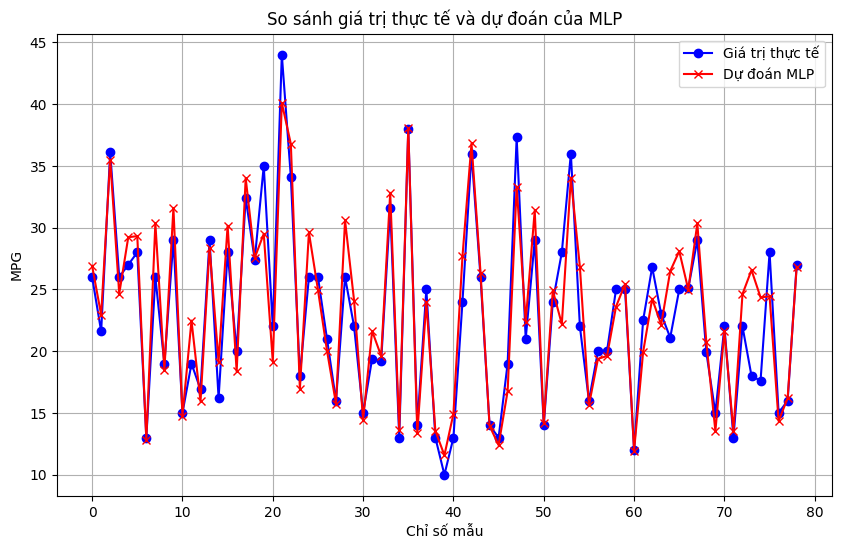

R² của MLP: 0.8780


In [16]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# Dự đoán từ mô hình MLP đã huấn luyện
y_pred_mlp = best_mlp.predict(X_test_scaled)

# Vẽ biểu đồ so sánh giữa giá trị thực tế và dự đoán
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(y_test)), y_test, label='Giá trị thực tế', color='b', marker='o')
plt.plot(np.arange(len(y_test)), y_pred_mlp, label='Dự đoán MLP', color='r', marker='x')
plt.xlabel('Chỉ số mẫu')
plt.ylabel('MPG')
plt.title('So sánh giá trị thực tế và dự đoán của MLP')
plt.legend()
plt.grid(True)
plt.show()

# In ra R² của dự đoán
r2 = r2_score(y_test, y_pred_mlp)
print(f"R² của MLP: {r2:.4f}")


c:\Users\tanhu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\tanhu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\tanhu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\tanhu\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the 

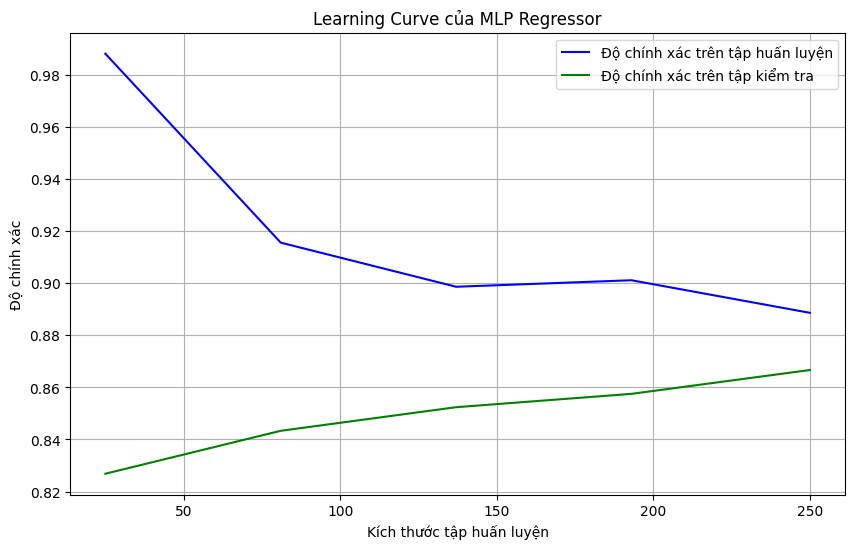

In [17]:
from sklearn.model_selection import learning_curve

# Vẽ Learning Curve
def plot_learning_curve(estimator, X, y, cv=5, n_jobs=None, train_sizes=np.linspace(0.1, 1.0, 5)):
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label="Độ chính xác trên tập huấn luyện", color="blue")
    plt.plot(train_sizes, test_scores_mean, label="Độ chính xác trên tập kiểm tra", color="green")
    plt.title("Learning Curve của MLP Regressor")
    plt.xlabel("Kích thước tập huấn luyện")
    plt.ylabel("Độ chính xác")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Gọi hàm để vẽ Learning Curve cho MLP
plot_learning_curve(best_mlp, X_train_scaled, y_train)


c:\Users\tanhu\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using 313 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 79/79 [00:10<00:00,  7.34it/s]


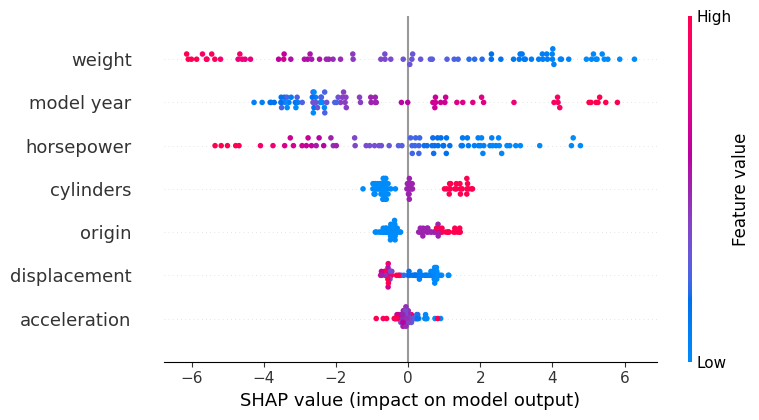

In [18]:
import shap

# Tạo đối tượng explainer cho mô hình MLP
explainer = shap.KernelExplainer(best_mlp.predict, X_train_scaled)

# Tính toán giá trị SHAP cho các mẫu trong tập kiểm tra
shap_values = explainer.shap_values(X_test_scaled[:100])

# Vẽ biểu đồ SHAP cho một số mẫu dữ liệu
shap.summary_plot(shap_values, X_test_scaled[:100], feature_names=X.columns)


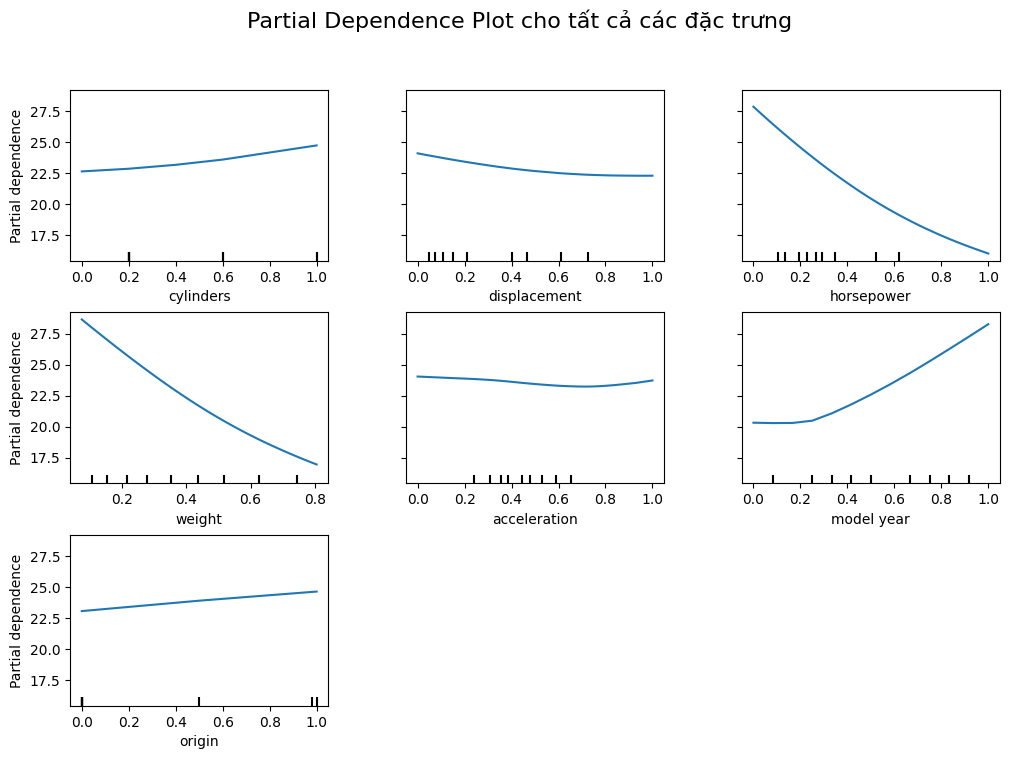

In [19]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# Thiết lập kích thước của biểu đồ và bố cục
fig, ax = plt.subplots(figsize=(12, 8))  # Tăng kích thước của hình ảnh

# Vẽ Partial Dependence Plot cho tất cả các đặc trưng
features = np.arange(X_train_scaled.shape[1])  # Tạo danh sách các chỉ số đặc trưng
display = PartialDependenceDisplay.from_estimator(best_mlp, X_train_scaled, features, feature_names=X.columns, ax=ax)

# Cập nhật tiêu đề và trục để dễ đọc hơn
plt.subplots_adjust(hspace=0.3, wspace=0.3)  # Điều chỉnh khoảng cách giữa các biểu đồ
plt.suptitle('Partial Dependence Plot cho tất cả các đặc trưng', fontsize=16)  # Tiêu đề chính

plt.show()


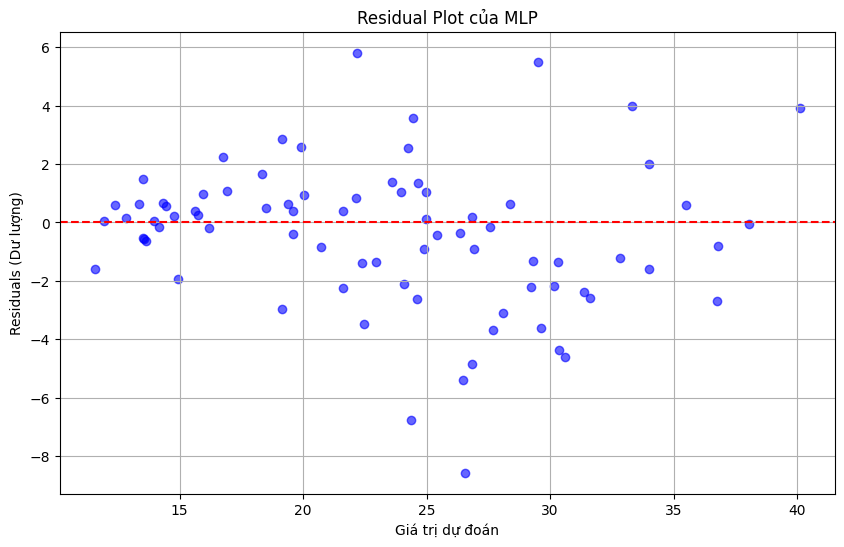

In [20]:
import matplotlib.pyplot as plt

# Dự đoán giá trị từ MLP
y_pred_mlp = best_mlp.predict(X_test_scaled)

# Tính dư lượng
residuals = y_test - y_pred_mlp

# Vẽ biểu đồ dư lượng
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_mlp, residuals, color="blue", alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Giá trị dự đoán')
plt.ylabel('Residuals (Dư lượng)')
plt.title('Residual Plot của MLP')
plt.grid(True)
plt.show()


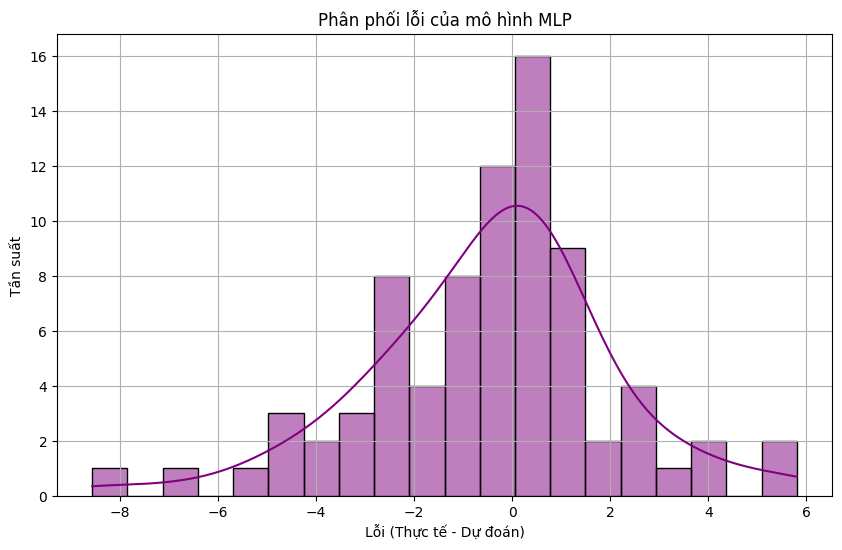

In [21]:
import seaborn as sns

# Tính toán lỗi
errors = y_test - y_pred_mlp

# Vẽ biểu đồ phân phối lỗi
plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, color='purple', bins=20)
plt.title('Phân phối lỗi của mô hình MLP')
plt.xlabel('Lỗi (Thực tế - Dự đoán)')
plt.ylabel('Tần suất')
plt.grid(True)
plt.show()


Using 313 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 79/79 [00:10<00:00,  7.34it/s]


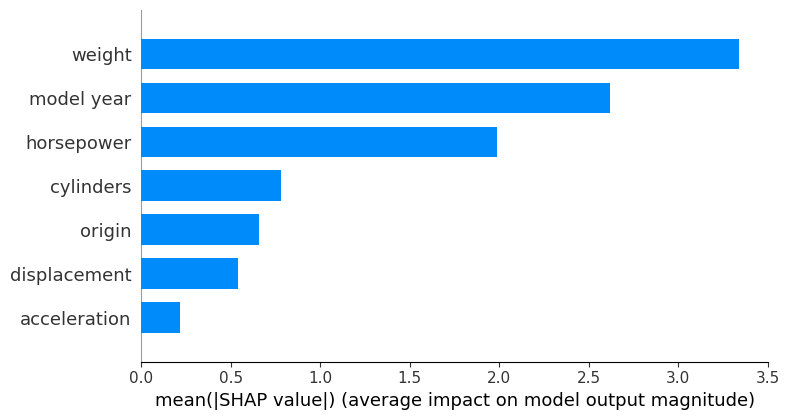

In [22]:
import shap

# Tính toán giá trị SHAP
explainer = shap.KernelExplainer(best_mlp.predict, X_train_scaled)
shap_values = explainer.shap_values(X_test_scaled[:100])

# Vẽ SHAP bar plot
shap.summary_plot(shap_values, X_test_scaled[:100], feature_names=X.columns, plot_type="bar")


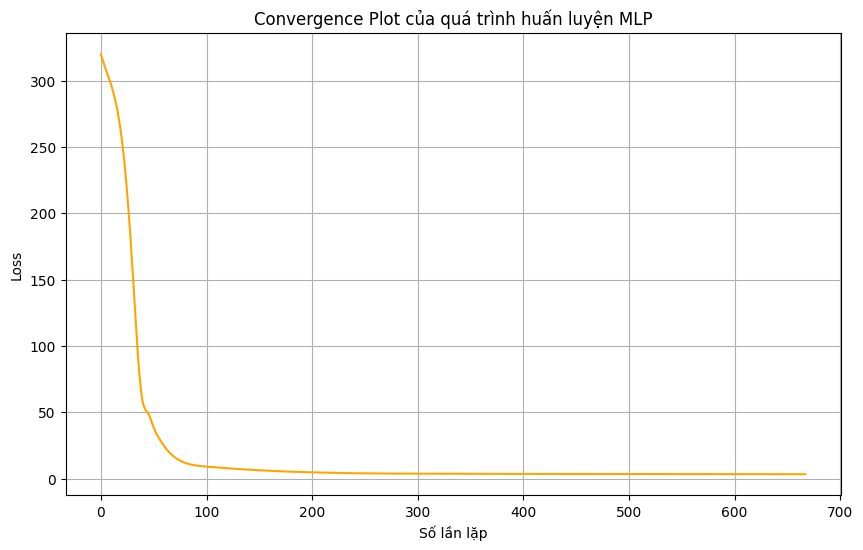

In [23]:
# Truy xuất loss trong quá trình huấn luyện
plt.figure(figsize=(10, 6))
plt.plot(best_mlp.loss_curve_, color='orange')
plt.title('Convergence Plot của quá trình huấn luyện MLP')
plt.xlabel('Số lần lặp')
plt.ylabel('Loss')
plt.grid(True)
plt.show()
